<a href="https://www.kaggle.com/code/saptaksen/mental-health-analysis-and-support?scriptVersionId=232494682" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Mental Health Text Analysis and Support System
## Capstone Project for Google Gen AI Intensive Course

**Author:** Saptak

## Overview

This notebook demonstrates the application of generative AI to address mental health support systems. Mental health is a critical global health priority, but access to quality support remains challenging for many. This project showcases how generative AI can assist in analyzing text data to identify mental health concerns and provide appropriate support responses.

### Gen AI Capabilities Demonstrated:
1. **Retrieval Augmented Generation (RAG)** - To provide evidence-based mental health information
2. **Few-shot prompting** - To improve specialized mental health response generation
3. **Structured output/JSON mode** - To categorize and analyze mental health text data
4. **Long context window** - To maintain conversation history for coherent support conversations
5. **Document understanding** - To analyze and extract insights from mental health literature
6. **Agentic Workflows with LangGraph** - To orchestrate analysis, retrieval, and response generation in a structured manner.

### Problem Statement:
Mental health support systems face several challenges:
- Limited availability of mental health professionals
- Delays in identifying concerning patterns in communication
- Need for consistent, evidence-based responses
- Privacy and personalization requirements

This project creates an AI-assisted system that can:
1. Analyze text data to identify potential mental health concerns
2. Categorize the type and severity of concerns
3. Generate appropriate, empathetic responses
4. Provide evidence-based information from reliable sources
5. Maintain contextual awareness for ongoing supportive conversations
6. Execute a defined workflow for handling user input using LangGraph.

## Setup and Dependencies

Using minimal dependencies with Kaggle's pre-installed packages whenever possible.

In [1]:
# Install all essential packages
!pip install -q "google-genai==1.7.0" "chromadb==0.6.3" kagglehub langgraph nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.4/142.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.2 MB/s eta 0

In [2]:
# imports
import os, json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Image
from typing import TypedDict, Dict, Any
import nltk

# Import specialized libraries
import google.generativeai as genai
import chromadb
import kagglehub
from langgraph.graph import StateGraph, END
from kaggle_secrets import UserSecretsClient

# Download NLTK data
nltk.download('punkt', quiet=True)

True

## Configure Google Gemini API

We'll use the Google Gemini API for this project. The API key is stored as a Kaggle secret.

In [3]:
# Get API key and configure Gemini API
user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize model
model_name = 'models/gemini-2.5-pro-preview-03-25'
model = genai.GenerativeModel(model_name)
print(f"\nUsing model: {model_name}")

# Test the model
response = model.generate_content("Hello, can you introduce yourself as a mental health support assistant?")
print(response.text)


Using model: models/gemini-2.5-pro-preview-03-25
Okay, here's an introduction in that role:

Hello! You can think of me as an AI Mental Health Support Assistant.

My purpose here is to provide a supportive and non-judgmental space for you. I'm here to listen if you need to talk through something, offer information on various mental health topics, share potential coping strategies or grounding techniques, and help you explore resources if you're looking for further support.

It's really important to understand what I **can** and **cannot** do:

*   **I can:** Offer a listening ear, provide general information, suggest common coping mechanisms, and point you towards resources like articles, organizations, or types of professional help.
*   **I cannot:** Provide therapy, diagnosis, or medical advice. I am an AI, not a licensed human professional (like a therapist, counselor, or doctor). My responses are based on information I've been trained on and should not replace professional consult

## Data Acquisition

For this project, we'll use publicly available datasets from Kaggle related to mental health. We'll focus on three key datasets:

1. Mental Health in Tech Survey - A dataset containing survey responses about mental health in the tech workplace
2. Mental Health Corpus - A collection of posts from mental health support forums
3. Suicide Prevention Dataset - Containing text data related to suicide risk identification

Let's load these datasets using Kaggle's dataset API:

In [4]:
# Function to load dataset and display basic info
def load_dataset(dataset_path, file_name, description):
    path = kagglehub.dataset_download(dataset_path)
    df = pd.read_csv(os.path.join(path, file_name))
    print(f"{description}:")
    print(f"Shape: {df.shape}")
    display(df.head())
    return df

# Load all three datasets
tech_survey_df = load_dataset('osmi/mental-health-in-tech-survey', 'survey.csv', 
                             "Mental Health in Tech Survey Dataset")

mental_health_posts_df = load_dataset('reihanenamdari/mental-health-corpus', 'mental_health.csv',
                                     "Mental Health Corpus Dataset")

suicide_prevention_df = load_dataset('nikhileswarkomati/suicide-watch', 'Suicide_Detection.csv',
                                    "Suicide Prevention Dataset")

Mental Health in Tech Survey Dataset:
Shape: (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


Mental Health Corpus Dataset:
Shape: (27977, 2)


,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


Suicide Prevention Dataset:
Shape: (232074, 3)


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## Data Exploration and Preprocessing

Let's explore these datasets and prepare them for our analysis.

In [5]:
# Check for missing values in Tech Survey dataset
print("Missing values in Tech Survey dataset:")
print(tech_survey_df.isnull().sum().sort_values(ascending=False).head(10))

# Check value distribution for key columns
for col in ['treatment', 'work_interfere']:
    if col in tech_survey_df.columns:
        print(f"\nDistribution of '{col}' column:")
        print(tech_survey_df[col].value_counts())

Missing values in Tech Survey dataset:
comments                   1095
state                       515
work_interfere              264
self_employed                18
seek_help                     0
obs_consequence               0
mental_vs_physical            0
phys_health_interview         0
mental_health_interview       0
supervisor                    0
dtype: int64

Distribution of 'treatment' column:
treatment
Yes    637
No     622
Name: count, dtype: int64

Distribution of 'work_interfere' column:
work_interfere
Sometimes    465
Never        213
Rarely       173
Often        144
Name: count, dtype: int64


Mental Health Corpus Labels:
label
0    14139
1    13838
Name: count, dtype: int64


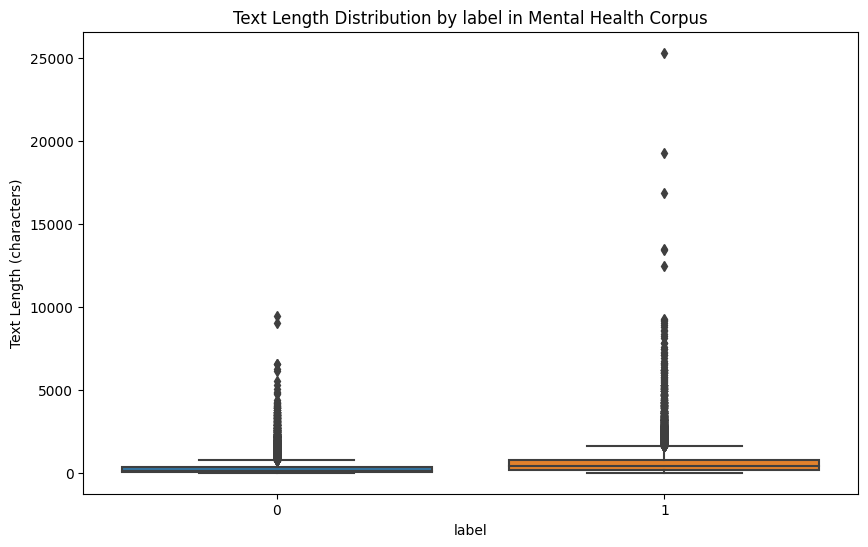

Suicide Prevention Dataset Labels:
class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


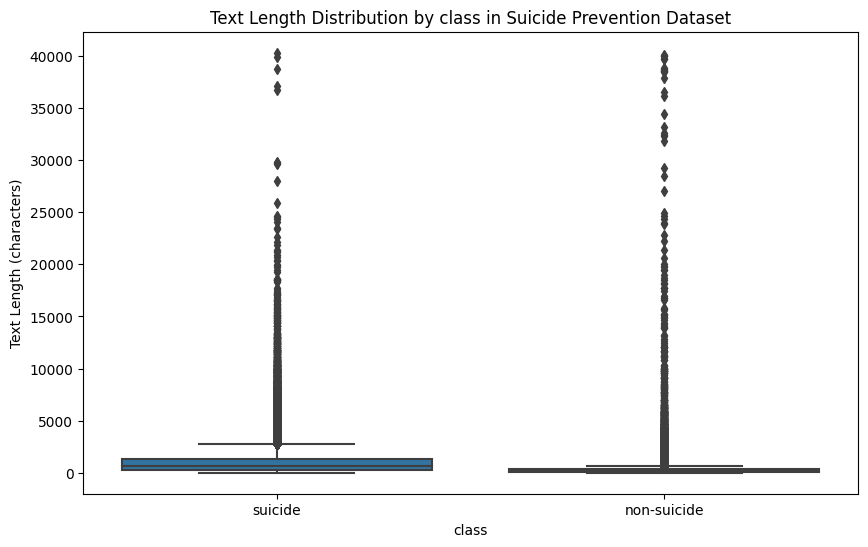

In [6]:
# Text length calculation and visualization function
def analyze_text_lengths(df, text_col, label_col=None, title_prefix=""):
    df['text_length'] = df[text_col].apply(len)
    df['text_length'] = df['text_length'].replace([np.inf, -np.inf], np.nan)
    
    if label_col:
        print(f"{title_prefix} Labels:")
        print(df[label_col].value_counts())
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=label_col, y='text_length', data=df.dropna(subset=['text_length']))
        plt.title(f'Text Length Distribution by {label_col} in {title_prefix}')
        plt.xlabel(label_col)
        plt.ylabel('Text Length (characters)')
    else:
        plt.figure(figsize=(10, 6))
        sns.histplot(df['text_length'].dropna(), bins=50)
        plt.title(f'Distribution of Text Lengths in {title_prefix}')
        plt.ylabel('Count')
        plt.xlabel('Text Length (characters)')
    
    plt.show()

# Analyze both datasets
analyze_text_lengths(mental_health_posts_df, 'text', 'label', "Mental Health Corpus")
analyze_text_lengths(suicide_prevention_df, 'text', 'class', "Suicide Prevention Dataset")

## Data Preprocessing

Let's prepare our datasets for analysis.

In [7]:
# Function to clean text data
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ''

# Process all datasets
for df, name in [(mental_health_posts_df, 'Mental Health Corpus'),
                (suicide_prevention_df, 'Suicide Prevention')]:
    df['cleaned_text'] = df['text'].apply(clean_text)

# Display sample of cleaned data
print("Sample of cleaned mental health text:")
for i, row in mental_health_posts_df[['cleaned_text', 'label']].head(3).iterrows():
    print(f"Label: {row['label']}")
    print(f"Text: {row['cleaned_text'][:200]}...\n")

Sample of cleaned mental health text:
Label: 0
Text: dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math...

Label: 1
Text: nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang myself...

Label: 0
Text: music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhymesay...



## Gen AI Capability 1: Structured Output/JSON Mode

Let's use Gemini's structured output capability to analyze and categorize mental health text data.

In [8]:
# Define the structured output schema for mental health text analysis
analysis_schema = genai.types.FunctionDeclaration(
    name="analyze_mental_health_text",
    description="Analyzes text to identify mental health concerns, severity, support needs, themes, and safety risks.",
    parameters={
        'type_': 'OBJECT',
        'properties': {
            'primary_concern': {'type': 'STRING', 'description': "The main mental health concern identified (e.g., depression, anxiety, stress, trauma, addiction, eating_disorder, self_harm, suicidal_ideation, bipolar, schizophrenia, other, none).", 'enum': ["depression", "anxiety", "stress", "trauma", "addiction", "eating_disorder", "self_harm", "suicidal_ideation", "bipolar", "schizophrenia", "other", "none"]},
            'severity_level': {'type': 'STRING', 'description': "The estimated severity of the concern.", 'enum': ["mild", "moderate", "severe", "crisis", "unclear"]},
            'support_needed': {'type': 'ARRAY', 'items': {'type': 'STRING'}, 'description': "Types of support that might be helpful (e.g., emotional_support, professional_help, crisis_intervention, information, coping_strategies, community_resources, peer_support)."},
            'key_themes': {'type': 'ARRAY', 'items': {'type': 'STRING'}, 'description': "Keywords or themes mentioned in the text."},
            'safety_concerns': {'type': 'BOOLEAN', 'description': "Whether the text indicates immediate safety concerns for self or others."},
            'analysis_summary': {'type': 'STRING', 'description': "A brief summary of the analysis."}
        },
        'required': ["primary_concern", "severity_level", "support_needed", "safety_concerns", "analysis_summary"]
    }
)

# Tool definition for the model
analysis_tool = genai.types.Tool(function_declarations=[analysis_schema])

In [9]:
# Function to analyze mental health text using the defined tool/schema
def analyze_mental_health_text_tool(text: str) -> Dict[str, Any]:
    # Default result for error cases
    default_result = {
        'primary_concern': 'unclear',
        'severity_level': 'unclear',
        'support_needed': [],
        'key_themes': [],
        'safety_concerns': False,
        'analysis_summary': 'Analysis failed: Could not process API response.'
    }
    
    # Create prompt for the analysis
    prompt = f"Please analyze the following text for mental health concerns using the 'analyze_mental_health_text' tool. "
    prompt += f"Focus on identifying the primary concern, severity, support needs, key themes, and any safety risks. "
    prompt += f"Be cautious not to over-interpret normal emotional experiences. If safety concerns are present, flag them explicitly.\n\n"
    prompt += 'Text: "' + text + '"\n'
    
    # Get response from the model
    response = model.generate_content(prompt, tools=[analysis_tool])
    
    # Validate response has candidates
    if not response.candidates:
        print("Warning: API response contained no candidates. Returning default analysis.")
        if hasattr(response, 'prompt_feedback') and response.prompt_feedback:
             print(f"Prompt Feedback: {response.prompt_feedback}")
        return default_result
    
    # Extract function call arguments
    candidate = response.candidates[0]
    args = None
    if (hasattr(candidate, 'content') and candidate.content and 
        hasattr(candidate.content, 'parts') and candidate.content.parts):
        
        for part in candidate.content.parts:
            if (hasattr(part, 'function_call') and part.function_call and 
                part.function_call.name == "analyze_mental_health_text"):
                args = part.function_call.args if hasattr(part.function_call, 'args') else {}
                break
    
    # Handle case when function call not found
    if not args:
        print("Warning: No valid function call found in model response.")
        return default_result

    # Process results with defaults for missing fields
    analysis_result = {
        'primary_concern': args.get('primary_concern', 'unclear'),
        'severity_level': args.get('severity_level', 'unclear'),
        'support_needed': list(args.get('support_needed', [])),
        'key_themes': list(args.get('key_themes', [])),
        'safety_concerns': bool(args.get('safety_concerns', False)),
        'analysis_summary': args.get('analysis_summary', 'Analysis summary missing.')
    }
    
    # Ensure list fields are actually lists
    for field in ['support_needed', 'key_themes']:
        if not isinstance(analysis_result[field], list):
            analysis_result[field] = [analysis_result[field]] if analysis_result[field] else []
    
    return analysis_result

In [10]:
# Test samples for the analysis tool
sample_texts_tool = [
    # Depression indication
    "I've been feeling really down for the past month. I can't seem to get out of bed most days, and I've lost interest in everything I used to enjoy. I'm sleeping too much but still feel exhausted all the time.",
    
    # Anxiety indication
    "My heart keeps racing and I feel like something terrible is about to happen. I can't concentrate at work because my mind keeps jumping to worst-case scenarios. I've started avoiding social situations because I get so nervous.",
    
    # Crisis indication
    "I don't see any point in continuing anymore. I've written notes to my family. No one would really miss me anyway. I've been thinking about the best way to end things."
]

# Test each sample
for i, text in enumerate(sample_texts_tool):
    print(f"Sample {i+1}:")
    print(f"Text: {text}")
    analysis = analyze_mental_health_text_tool(text)
    print("\nAnalysis (Tool Output):")
    print(json.dumps(analysis, indent=2))
    print("\n" + "-"*80 + "\n")

Sample 1:
Text: I've been feeling really down for the past month. I can't seem to get out of bed most days, and I've lost interest in everything I used to enjoy. I'm sleeping too much but still feel exhausted all the time.

Analysis (Tool Output):
{
  "primary_concern": "depression",
  "severity_level": "moderate",
  "support_needed": [
    "professional_help",
    "emotional_support",
    "coping_strategies",
    "information"
  ],
  "key_themes": [
    "low mood",
    "loss of interest",
    "anhedonia",
    "fatigue",
    "hypersomnia",
    "low energy"
  ],
  "safety_concerns": false,
  "analysis_summary": "The user describes persistent symptoms over the past month including low mood, anhedonia (loss of interest), hypersomnia, and fatigue/low energy, which are indicative of potential depression."
}

--------------------------------------------------------------------------------

Sample 2:
Text: My heart keeps racing and I feel like something terrible is about to happen. I can't co

## Gen AI Capability 2: Retrieval Augmented Generation (RAG)

Let's implement a simple RAG system using the Gemini API for embeddings and ChromaDB.

In [11]:
# Mental health information documents
mental_health_documents = [
    # Depression information from Mayo Clinic
    """Depression is a mood disorder that causes a persistent feeling of sadness and loss of interest. Also called major depressive disorder or clinical depression, it affects how you feel, think and behave and can lead to a variety of emotional and physical problems. You may have trouble doing normal day-to-day activities, and sometimes you may feel as if life isn't worth living. More than just a bout of the blues, depression isn't a weakness and you can't simply 'snap out' of it. Depression may require long-term treatment. But don't get discouraged. Most people with depression feel better with medication, psychotherapy or both. Depression symptoms can vary from mild to severe and may include: Feeling sad or having a depressed mood, Loss of interest or pleasure in activities once enjoyed, Changes in appetite — weight loss or gain unrelated to dieting, Trouble sleeping or sleeping too much, Loss of energy or increased fatigue, Increase in purposeless physical activity or slowed movements and speech, Feeling worthless or guilty, Difficulty thinking, concentrating or making decisions, Thoughts of death or suicide""",
    
    # Anxiety information from NIMH
    """Anxiety disorders are characterized by excessive worry, nervousness, or fear that is difficult to control and interferes with daily activities. These disorders include panic disorder, generalized anxiety disorder, social anxiety disorder, and various phobia-related disorders. Common symptoms of anxiety include: Feeling restless, wound-up, or on-edge, Being easily fatigued, Having difficulty concentrating, Being irritable, Having headaches, muscle aches, stomachaches, or unexplained pains, Difficulty controlling feelings of worry, Having sleep problems, such as difficulty falling or staying asleep. Effective treatments for anxiety disorders include psychotherapy (particularly cognitive-behavioral therapy), medication, or a combination of the two. Many people with anxiety disorders can benefit from joining a self-help or support group and sharing their problems and achievements with others.""",
    
    # Crisis intervention from American Foundation for Suicide Prevention
    """If you or someone you know is in crisis, contact the 988 Suicide & Crisis Lifeline that provides 24/7, free and confidential support. Call or text 988, or chat at 988lifeline.org. For emergency situations, call 911 or visit your local emergency room. Warning signs of suicide may include: Talking about wanting to die or to kill oneself, Looking for ways to kill oneself, such as searching online or buying a gun, Talking about feeling hopeless or having no reason to live, Talking about feeling trapped or in unbearable pain, Talking about being a burden to others, Increasing use of alcohol or drugs, Acting anxious or agitated; behaving recklessly, Sleeping too little or too much, Withdrawing or feeling isolated, Showing rage or talking about seeking revenge, Displaying extreme mood swings. If someone is showing these warning signs, don't leave them alone, remove potential means of harm, and call the crisis line or take them to an emergency room.""",
    
    # Coping strategies from APA
    """Healthy coping strategies for managing stress and mental health challenges include: 1. Practice relaxation techniques: Deep breathing, meditation, progressive muscle relaxation. 2. Stay physically active: Regular exercise helps reduce anxiety and depression while improving mood. 3. Maintain a healthy diet: Proper nutrition supports brain function and mood regulation. 4. Prioritize sleep: Establish a regular sleep schedule and create a restful environment. 5. Connect with others: Social support is crucial for mental wellbeing. 6. Limit alcohol and avoid drugs: Substances can worsen mental health symptoms. 7. Set realistic goals: Break large tasks into smaller, manageable steps. 8. Practice self-compassion: Treat yourself with the same kindness you would offer a friend. 9. Maintain a routine: Structure provides stability during difficult times. 10. Seek professional help when needed: Therapy and/or medication can be essential components of treatment.""",
    
    # Workplace mental health
    """Creating mentally healthy workplaces involves: 1. Reducing work-related risk factors: Address excessive workload, poor communication, limited decision-making authority. 2. Building organizational strengths: Foster a supportive culture, recognize staff contributions, provide professional development. 3. Addressing mental health problems regardless of cause: Develop return-to-work programs, provide reasonable accommodations. 4. Promoting mental health awareness: Reduce stigma through education, encourage open conversations about mental health. 5. Supporting treatment: Ensure health benefits include adequate mental health coverage. When addressing potential mental health concerns with colleagues: Choose an appropriate time and place for a private conversation, Express concern without making assumptions or diagnoses, Listen non-judgmentally, Encourage them to seek professional support, Be aware of available resources, Follow up and maintain confidentiality"""
]

In [12]:
# Text chunking and embedding functions
def split_into_chunks(text, chunk_size=500, overlap=100):
    chunks = []
    start = 0
    text_length = len(text)
    
    while start < text_length:
        end = min(start + chunk_size, text_length)
        # Try to end on sentence boundary
        if end < text_length:
            period_pos = text.rfind('.', start + chunk_size - overlap, end)
            if period_pos != -1:
                end = period_pos + 1
            else: # Fallback to space
                space_pos = text.rfind(' ', start + chunk_size - overlap, end)
                if space_pos != -1:
                    end = space_pos + 1
        
        chunk = text[start:end].strip()
        if chunk:  # Only add non-empty chunks
            chunks.append(chunk)
        
        # Move start position for next chunk
        start = max(end - overlap, start + 1) 
            
    return chunks

# Process document chunks
all_chunks = []
for i, doc in enumerate(mental_health_documents):
    chunks = split_into_chunks(doc)
    # Add metadata to each chunk
    for j, chunk in enumerate(chunks):
        all_chunks.append({"id": f"doc_{i}_chunk_{j}", "text": chunk, "source": f"Document {i+1}"})

print(f"Total chunks created: {len(all_chunks)}")
if all_chunks:
    print("\nSample chunk:")
    print(all_chunks[0])

Total chunks created: 515

Sample chunk:
{'id': 'doc_0_chunk_0', 'text': "Depression is a mood disorder that causes a persistent feeling of sadness and loss of interest. Also called major depressive disorder or clinical depression, it affects how you feel, think and behave and can lead to a variety of emotional and physical problems. You may have trouble doing normal day-to-day activities, and sometimes you may feel as if life isn't worth living. More than just a bout of the blues, depression isn't a weakness and you can't simply 'snap out' of it.", 'source': 'Document 1'}


In [13]:
# Embedding and vector store setup
embedding_model_name = "models/embedding-001"

def get_embeddings(texts, task_type="retrieval_document"):
    result = genai.embed_content(
        model=embedding_model_name,
        content=texts,
        task_type=task_type
    )
    return result['embedding']

# Generate embeddings for all chunks
chunk_texts = [chunk['text'] for chunk in all_chunks]
chunk_embeddings = get_embeddings(chunk_texts)

# Prepare data for ChromaDB
ids = [chunk['id'] for chunk in all_chunks]
metadatas = [{"source": chunk['source']} for chunk in all_chunks]

print(f"Generated embeddings for {len(chunk_texts)} text chunks")
if chunk_embeddings:
    print(f"Dimension of embeddings: {len(chunk_embeddings[0])}")

Generated embeddings for 515 text chunks
Dimension of embeddings: 768


In [14]:
# Set up ChromaDB collection
collection = None
try:
    # Initialize ChromaDB client
    chroma_client = chromadb.Client()
    collection_name = "mental_health_info"
    
    # Delete collection if it exists
    try:
        chroma_client.delete_collection(name=collection_name)
        print(f"Deleted existing collection '{collection_name}'")
    except Exception:
        pass
        
    # Create new collection
    collection = chroma_client.create_collection(name=collection_name)
    
    # Add document chunks and embeddings
    if chunk_embeddings and chunk_texts and metadatas and ids:
        collection.add(
            embeddings=chunk_embeddings,
            documents=chunk_texts,
            metadatas=metadatas,
            ids=ids
        )
        print(f"Added {collection.count()} documents to ChromaDB collection")
    else:
        print("Missing required data for ChromaDB")
        collection = None
        
except Exception as e:
    print(f"Error setting up ChromaDB: {e}")

Added 515 documents to ChromaDB collection


In [15]:
# RAG retrieval function
def retrieve_relevant_info_rag(query: str, top_k: int = 3) -> str:
    if collection is None:
        return "[Error: ChromaDB collection not available]"
    
    # Get query embedding
    query_embedding = get_embeddings([query], task_type="retrieval_query")[0]
    
    # Search the collection
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k,
        include=['documents', 'metadatas', 'distances']
    )
    
    # Format results
    context = ""
    if results and results.get('documents') and results['documents'][0]:
        context += "Relevant Information Found:\n"
        for i, doc in enumerate(results['documents'][0]):
            source = results['metadatas'][0][i].get('source', 'Unknown')
            distance = results['distances'][0][i]
            # Only include relevant results (lower distance = more relevant)
            if distance < 1.5:
                context += f"---\nSource: {source}\nContent: {doc}\n(Relevance: {1/(1+distance):.2f})\n"
    
    return context.strip() or "[No relevant information found]"

# Test RAG retrieval
test_query = "I'm feeling very anxious and having trouble sleeping. What can I do?"
retrieved_info = retrieve_relevant_info_rag(test_query)

print(f"Query: {test_query}\n")
print("Retrieved Information:")
print(retrieved_info)

Query: I'm feeling very anxious and having trouble sleeping. What can I do?

Retrieved Information:
Relevant Information Found:
---
Source: Document 2
Content: Anxiety disorders are characterized by excessive worry, nervousness, or fear that is difficult to control and interferes with daily activities. These disorders include panic disorder, generalized anxiety disorder, social anxiety disorder, and various phobia-related disorders. Common symptoms of anxiety include: Feeling restless, wound-up, or on-edge, Being easily fatigued, Having difficulty concentrating, Being irritable, Having headaches, muscle aches, stomachaches, or unexplained pains,
(Relevance: 0.62)
---
Source: Document 2
Content: concentrating, Being irritable, Having headaches, muscle aches, stomachaches, or unexplained pains, Difficulty controlling feelings of worry, Having sleep problems, such as difficulty falling or staying asleep. Effective treatments for anxiety disorders include psychotherapy (particularly cognit

## Gen AI Capability 3: Few-Shot Prompting for Response Generation

In [16]:
# Response generation prompt template
FEW_SHOT_RESPONSE_PROMPT_TEMPLATE = """
You are an empathetic and supportive mental health assistant. 
Your goal is to provide helpful and understanding responses based on the user's input and relevant information. 
Do NOT diagnose. Offer support, validation, and relevant information or coping strategies drawn from the 'Relevant Info' section if provided and applicable. 
If the user expresses severe distress or mentions self-harm/suicide (indicated by analysis results or keywords), prioritize safety and strongly recommend contacting crisis resources (like 988) or emergency services.

--- Analysis Results ---
{analysis_results_str}

--- Relevant Info ---
{retrieved_context}

--- User Input ---
{user_input}

--- Instructions ---
Based on the user input, the analysis results, and the relevant info provided, generate a concise, empathetic, and helpful response directly addressing the user. 
1. Acknowledge the user's feelings.
2. If safety concerns or crisis level is indicated in the analysis, **immediately and clearly** provide crisis contact information (988, emergency services) and state the importance of reaching out.
3. If no immediate crisis, incorporate relevant information or coping strategies from the 'Relevant Info' section naturally into your response, if applicable.
4. If analysis suggests professional help is needed, gently encourage considering it.
5. Keep the tone supportive and conversational. Avoid sounding robotic or just listing information.
6. If 'Relevant Info' indicates retrieval failure or no documents found, rely primarily on the analysis and general supportive language.

Response:
"""

# Response generation function
def generate_support_response_llm(user_input: str, retrieved_context: str, analysis_results: Dict[str, Any]) -> str:
    # Format analysis results as JSON string
    analysis_results_str = json.dumps(analysis_results, indent=2)
    
    # Build prompt with all context
    prompt = FEW_SHOT_RESPONSE_PROMPT_TEMPLATE.format(
        user_input=user_input,
        retrieved_context=retrieved_context,
        analysis_results_str=analysis_results_str
    )
    
    # Generate response
    response = model.generate_content(prompt)
    
    # Extract text from response
    try:
        if hasattr(response, 'text') and response.text:
            return response.text
        elif response.candidates and response.candidates[0].content and response.candidates[0].content.parts:
            return response.candidates[0].content.parts[0].text
        else:
            return "I'm here to listen. Could you tell me a bit more?"
    except Exception as e:
        print(f"Error extracting response: {e}")
        return "I'm here to listen. Could you tell me a bit more?"

# Test response generation
test_input = "I had a panic attack yesterday and I'm scared it will happen again. My chest gets tight and I can't breathe."
test_analysis = analyze_mental_health_text_tool(test_input)
test_context = retrieve_relevant_info_rag(test_input, top_k=2)
response = generate_support_response_llm(test_input, test_context, test_analysis)

print(f"User Input: {test_input}\n")
print("Generated Response:")
display(Markdown(response))

User Input: I had a panic attack yesterday and I'm scared it will happen again. My chest gets tight and I can't breathe.

Generated Response:


That sounds really frightening. Experiencing a panic attack, especially with symptoms like chest tightness and difficulty breathing, can be incredibly scary, and it's completely understandable that you're worried about it happening again.

Those physical sensations, like the chest tightness you described, can be part of anxiety and panic attacks. Please know that you're not alone in feeling this way. Since these experiences are causing you distress and fear, it might be helpful to talk to a doctor or a mental health professional. They can help you understand why this is happening and explore ways to manage these feelings and physical symptoms, perhaps through approaches like therapy or other support strategies. Reaching out for support can make a real difference.

## Gen AI Capability 4: Long Context Window (Simulated Conversation)

In [17]:
# Start a chat session with context
chat = model.start_chat(history=[])

# Set initial context
initial_prompt = "You are a supportive mental health assistant. Use the principles from the few-shot examples: be empathetic, don't diagnose, offer support and relevant information (like coping strategies), and prioritize safety if crisis signs appear. Keep responses concise and conversational."
chat.history = [
    {'role': 'user', 'parts': [initial_prompt]},
    {'role': 'model', 'parts': ["Understood. I will act as a supportive mental health assistant, following those guidelines. How can I help you today?"]}
]

# Simulate conversation
conversation_turns = [
    "I've been feeling really anxious about an upcoming presentation.",
    "Thanks, that's helpful. What are some quick grounding techniques I could use if I feel overwhelmed just before?",
    "Okay, I'll try the 5-4-3-2-1 technique. It's just hard because I feel like everyone will judge me.",
    "That's a good reminder. I appreciate you listening."
]

print("Chat session started. Simulating a conversation:\n")
for turn in conversation_turns:
    print(f"User: {turn}")
    response = chat.send_message(turn)
    print(f"\nAssistant:")
    display(Markdown(response.text if hasattr(response, 'text') else 
                     response.candidates[0].content.parts[0].text if response.candidates else 
                     "[No response generated]"))
    print("\n" + "-"*80 + "\n")

Chat session started. Simulating a conversation:

User: I've been feeling really anxious about an upcoming presentation.

Assistant:


It's completely understandable to feel anxious before a presentation – that's really common! Sometimes practicing beforehand or trying some deep breathing exercises can help calm those nerves. Would you like to talk more about what's making you feel anxious?


--------------------------------------------------------------------------------

User: Thanks, that's helpful. What are some quick grounding techniques I could use if I feel overwhelmed just before?

Assistant:


That's a great question! When you feel overwhelmed, focusing on your senses can really help bring you back to the present moment.

Here are a couple of quick ones:

1.  **5-4-3-2-1 Technique (Quick Version):** Silently notice **3** things you can see, **2** things you can hear, and **1** thing you can feel (like your feet on the floor or your hands resting on something).
2.  **Feel Your Feet:** Really concentrate on the sensation of your feet planted firmly on the ground. Wiggle your toes a bit inside your shoes. This helps anchor you physically.

These can be done anywhere, even right before you go on. Would trying one of those sound helpful?


--------------------------------------------------------------------------------

User: Okay, I'll try the 5-4-3-2-1 technique. It's just hard because I feel like everyone will judge me.

Assistant:


That fear of being judged is really tough, and it's something many people worry about when presenting. It can feel like all eyes are on you.

Sometimes it helps to gently remind yourself that people are often more focused on the information you're sharing, or even just thinking about their own day, rather than critically judging you.

Using that 5-4-3-2-1 technique right before can definitely help manage that intense feeling of being watched when it pops up. Is there anything specific about the judgment that feels particularly strong?


--------------------------------------------------------------------------------

User: That's a good reminder. I appreciate you listening.

Assistant:


You're very welcome! I'm glad I could listen. Remember those techniques, and know that it's okay to feel nervous. I'm here if anything else comes up or if you just want to talk more.


--------------------------------------------------------------------------------



## Gen AI Capability 5: Document Understanding

In [18]:
# Sample research abstract
document_text = """
Abstract: Cognitive Behavioral Therapy (CBT) remains a cornerstone in the treatment of anxiety disorders. 
This meta-analysis reviews 50 randomized controlled trials (RCTs) published between 2015 and 2023, 
evaluating the efficacy of CBT compared to control conditions (waitlist, placebo, treatment-as-usual) 
for Generalized Anxiety Disorder (GAD), Panic Disorder (PD), and Social Anxiety Disorder (SAD). 
Results indicate large effect sizes (Cohen's d > 0.8) for CBT across all three disorders, 
with significant reductions in primary symptom measures post-treatment and at 6-month follow-up. 
Moderator analyses suggest that therapist experience and treatment duration positively influence outcomes. 
While digital delivery of CBT shows promise, particularly for accessibility, effect sizes were slightly smaller 
compared to face-to-face therapy (d = 0.7 vs d = 0.9). Dropout rates were comparable across delivery formats. 
Future research should focus on personalized CBT approaches and long-term efficacy beyond 12 months.
Limitations include heterogeneity in control conditions and outcome measures across studies.
"""

# Analyze the document
analysis_prompt = f"""
Analyze the following research abstract. Provide:
1. A concise summary of the main findings.
2. Key strengths of the research mentioned.
3. Key limitations mentioned.
4. Future research directions suggested.

Abstract:
{document_text}

Analysis:
"""

analysis_response = model.generate_content(analysis_prompt)

print("Document Analysis Result:")
display(Markdown(analysis_response.text if hasattr(analysis_response, 'text') else 
                "[No analysis generated]"))

Document Analysis Result:


Okay, here is an analysis of the provided research abstract:

**Analysis of the Research Abstract**

1.  **Concise Summary of Main Findings:**
    This meta-analysis confirms that Cognitive Behavioral Therapy (CBT) is highly effective (large effect size, d > 0.8) for treating Generalized Anxiety Disorder, Panic Disorder, and Social Anxiety Disorder compared to control conditions. These positive effects are maintained at 6-month follow-up. Better outcomes are associated with greater therapist experience and longer treatment duration. Digital CBT is a promising and accessible option, though slightly less effective (d=0.7) than traditional face-to-face CBT (d=0.9), with similar dropout rates between the two formats.

2.  **Key Strengths of the Research Mentioned:**
    *   **Methodology:** Uses a meta-analysis, synthesizing data from multiple studies for stronger conclusions.
    *   **Study Quality:** Based on Randomized Controlled Trials (RCTs), considered a high standard of evidence.
    *   **Sample Size:** Includes a substantial number of studies (50 RCTs).
    *   **Recency:** Focuses on recent literature (published 2015-2023).
    *   **Follow-up Data:** Includes assessment of outcomes at 6-month follow-up, indicating durability of effects.
    *   **Moderator Analysis:** Investigates factors (therapist experience, treatment duration, delivery format) that might influence CBT's effectiveness.
    *   **Comparative Analysis:** Directly compares face-to-face versus digital delivery formats.

3.  **Key Limitations Mentioned:**
    *   **Heterogeneity in Control Conditions:** The types of control groups (waitlist, placebo, treatment-as-usual) varied across the included studies, which can make comparisons less straightforward.
    *   **Heterogeneity in Outcome Measures:** The specific tools or scales used to measure anxiety symptoms differed across the studies, potentially impacting the consistency of results.

4.  **Future Research Directions Suggested:**
    *   **Personalization:** Focus on developing and evaluating personalized CBT approaches tailored to individual patient needs.
    *   **Long-Term Efficacy:** Investigate the effectiveness of CBT over longer periods, specifically beyond 12 months post-treatment.

## Gen AI Capability 6: Agentic Workflow with LangGraph

Let's implement a mental health support agent using LangGraph.

In [19]:
# Define the agent state
class MentalHealthAgentState(TypedDict):
    user_input: str
    analysis_results: Dict[str, Any]
    retrieved_context: str
    final_response: str

# Define agent nodes
def analyze_input_node(state: MentalHealthAgentState) -> Dict[str, Any]:
    """Analyzes the user input using structured output."""
    print("--- Node: Analyzing Input ---")
    user_input = state['user_input']
    analysis = analyze_mental_health_text_tool(user_input)
    print(f"Analysis Result: {json.dumps(analysis, indent=2)}")
    return {"analysis_results": analysis}

def retrieve_info_node(state: MentalHealthAgentState) -> Dict[str, str]:
    """Retrieves relevant information based on analysis."""
    print("--- Node: Retrieving Information (RAG) ---")
    analysis = state.get('analysis_results', {})
    
    # Determine search query based on analysis
    query = ""
    top_k = 1
    
    # Crisis path
    if analysis.get('safety_concerns', False) or analysis.get('severity_level') == 'crisis':
        query = "crisis intervention and immediate safety steps"
    # Concern-based path
    elif analysis.get('severity_level') in ['severe', 'moderate']:
        concern = analysis.get('primary_concern', 'mental health concern')
        themes = ", ".join(analysis.get('key_themes', []))
        query = f"{concern} coping strategies and professional help. {themes}"
        top_k = 2
    # Mild concern path
    elif analysis.get('severity_level') == 'mild' or analysis.get('primary_concern') not in ['unclear', 'none']:
        concern = analysis.get('primary_concern', 'mental health')
        query = f"mild {concern} coping strategies"
    # Themes-only path
    elif analysis.get('key_themes'):
        themes = ", ".join(analysis.get('key_themes', []))
        query = f"Information related to {themes}"
    # Default path
    else:
        return {"retrieved_context": "[No specific information retrieved]"}
             
    print(f"Retrieval Query: {query}")
    context = retrieve_relevant_info_rag(query, top_k=top_k)
    return {"retrieved_context": context}

def generate_response_node(state: MentalHealthAgentState) -> Dict[str, str]:
    """Generates a supportive response."""
    print("--- Node: Generating Response ---")
    response = generate_support_response_llm(
        user_input=state['user_input'],
        retrieved_context=state.get('retrieved_context', '[No information available]'),
        analysis_results=state['analysis_results']
    )
    return {"final_response": response}

def route_decider(state: MentalHealthAgentState) -> str:
    """Determines the next node."""
    print("--- Route Decider ---") 
    analysis = state.get('analysis_results', {})
    
    # Routing logic
    if (analysis.get('safety_concerns', False) or 
        analysis.get('severity_level') in ['crisis', 'severe', 'moderate'] or 
        (analysis.get('primary_concern') not in ['unclear', 'none']) or
        analysis.get('key_themes')):
        decision = "retrieve_info"
    else:
        decision = "generate_response"
    
    print(f"Routing Decision: {decision}")
    return decision

In [20]:
# Build the graph
app = None
try:
    # Create the graph builder
    graph_builder = StateGraph(MentalHealthAgentState)
    
    # Add nodes
    graph_builder.add_node("analyze_input", analyze_input_node)
    graph_builder.add_node("retrieve_info", retrieve_info_node)
    graph_builder.add_node("generate_response", generate_response_node)
    
    # Set entry point
    graph_builder.set_entry_point("analyze_input")

    # Add conditional edge based on analysis
    graph_builder.add_conditional_edges(
        "analyze_input",
        route_decider,
        {
            "retrieve_info": "retrieve_info",
            "generate_response": "generate_response"
        }
    )
    
    # Add remaining edges
    graph_builder.add_edge("retrieve_info", "generate_response")
    graph_builder.add_edge("generate_response", END)
    
    # Compile the graph
    app = graph_builder.compile()
    print("Graph compiled successfully")
    
except Exception as e:
    print(f"Error building LangGraph: {e}")

Graph compiled successfully


In [21]:
# Function to run the agent
def run_agent(user_input: str):
    if not app:
        print("Agent graph not compiled.")
        return {"user_input": user_input, "final_response": "Error: Agent not compiled."}
        
    try:
        # Run the agent graph
        return app.invoke({"user_input": user_input})
    except Exception as e:
        print(f"Error running agent: {e}")
        return {
            "user_input": user_input,
            "final_response": "I apologize, but I encountered an error processing your request."
        }

# Test the agent
test_input = "I've been feeling really down for weeks. I can't sleep well, and I've lost interest in things I used to enjoy."
result = run_agent(test_input) 

print("\n=== Final Agent Response ===\n")
if result and "final_response" in result:
    display(Markdown(result["final_response"]))
else:
    print("No response generated.")

--- Node: Analyzing Input ---
Analysis Result: {
  "primary_concern": "unclear",
  "severity_level": "unclear",
  "support_needed": [],
  "key_themes": [],
  "safety_concerns": false,
  "analysis_summary": "Analysis failed: Could not process API response."
}
--- Route Decider ---
Routing Decision: generate_response
--- Node: Generating Response ---

=== Final Agent Response ===



It sounds really tough to be feeling down for weeks, especially when it's affecting your sleep and your interest in things you usually enjoy. That must be really draining and difficult to cope with.

Since these feelings have been going on for a while, it might be helpful to talk to someone who can offer more specific support, like a doctor or a mental health professional. They can help understand what's going on and explore ways to feel better.

Please know you don't have to go through this alone, and reaching out is a really positive step.

## Conclusion

This notebook has demonstrated multiple Gen AI capabilities applied to a mental health support system:

1. **Structured Output Analysis**: Using a defined schema to categorize mental health concerns, severity, and recommendations.
2. **Retrieval Augmented Generation (RAG)**: Enhancing responses with relevant, trusted mental health information.
3. **Few-Shot Learning**: Providing empathetic and appropriate responses based on example formats.
4. **Long Context Window**: Maintaining conversational context over multiple turns.
5. **Document Understanding**: Analyzing and extracting insights from mental health literature.
6. **Agentic Workflow**: Orchestrating multiple steps in a structured process using LangGraph.

These capabilities can be further enhanced and combined to create even more sophisticated mental health support systems to complement professional care.